In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import IPython
import IPython.display


from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from torch.autograd import Variable

# settings
plt.style.use('seaborn-deep')

import concurrent.futures
import requests
import time
from functools import partial
from datetime import datetime
import os
import warnings
warnings.filterwarnings(action='ignore')
import holidays
from sklearn.preprocessing import MinMaxScaler
import random

from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable

import torch
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import copy
from sklearn.cluster import KMeans
from collections import Counter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# ts = pd.read_csv("hourly2017-2018.csv", parse_dates=['timestamp'])
ts = pd.read_csv("hourly.csv", parse_dates=['timestamp'])
ts = ts.drop(['Unnamed: 0', 'reportingGroup', 'unit'],axis=1)
ts

,timestamp,locationName,value
0,2019-01-01 00:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
1,2019-01-01 01:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
2,2019-01-01 02:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
3,2019-01-01 03:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
4,2019-01-01 04:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
...,...,...,...
1184945,2019-03-31 23:20:00,4661 Kalasataman TeHyKe,0.00
1184946,2019-03-31 23:30:00,4661 Kalasataman TeHyKe,22.00
1184947,2019-03-31 23:40:00,4661 Kalasataman TeHyKe,0.00
1184948,2019-03-31 23:50:00,4661 Kalasataman TeHyKe,22.25


# 给每个client分数据

求和

In [86]:
client_n = 500
cluster_n = min(1, int(ts.locationName.nunique()/client_n))

user_name = ts.locationName.unique().tolist()
clients = []

for i in range(client_n):
    clients.append(user_name[i*cluster_n:(i+1)*cluster_n]) 
    
ts['client_id'] = 0
ts_new = pd.DataFrame(columns=ts.columns)
for i in range(client_n):
    for j in range(cluster_n):
        tmp = ts.loc[ts['locationName'] == clients[i][j]]
        tmp['client_id'] = i
        ts_new = pd.concat([ts_new, tmp])

ts_agg = pd.DataFrame(columns=ts_new.columns)
for i in range(client_n):
    tmp = ts_new.loc[ts_new['client_id'] == i].groupby('timestamp')['value'].apply(sum).to_frame()
    tmp['client_id'] = i
    ts_agg = pd.concat([ts_agg, tmp])
ts_agg = ts_agg.drop(['timestamp', 'locationName'],axis=1)
ts_agg = ts_agg.rename(columns={'value':'kWh'})
ts = ts_agg
ts

,kWh,client_id
2018-01-01 00:00:00,0.03,0
2018-01-01 01:00:00,0.04,0
2018-01-01 02:00:00,0.04,0
2018-01-01 03:00:00,0.04,0
2018-01-01 04:00:00,0.04,0
...,...,...
2018-12-31 20:00:00,26.28,99
2018-12-31 21:00:00,26.10,99
2018-12-31 22:00:00,26.04,99
2018-12-31 23:00:00,26.04,99


In [3]:
client_n = 100

user_name = ts.locationName.unique().tolist()
clients = []
for i in range(client_n):
    clients.append(user_name[i]) 

ts['client_id'] = 0
ts_new = pd.DataFrame(columns=ts.columns)
for i in range(client_n):
    tmp = ts.loc[ts['locationName'] == clients[i]]
    tmp['client_id'] = i
    ts_new = pd.concat([ts_new, tmp])
ts_new.set_index(['timestamp'], inplace=True)
ts_new = ts_new.drop(['locationName'],axis=1)
ts_new = ts_new.rename(columns={'value':'kWh'})
ts = ts_new
ts

,kWh,client_id
timestamp,,
2019-01-01 00:00:00,0.00,0
2019-01-01 01:00:00,0.00,0
2019-01-01 02:00:00,0.00,0
2019-01-01 03:00:00,0.00,0
2019-01-01 04:00:00,0.00,0
...,...,...
2019-03-31 20:00:00,3.33,99
2019-03-31 21:00:00,2.91,99
2019-03-31 22:00:00,3.06,99


<AxesSubplot:xlabel='timestamp'>

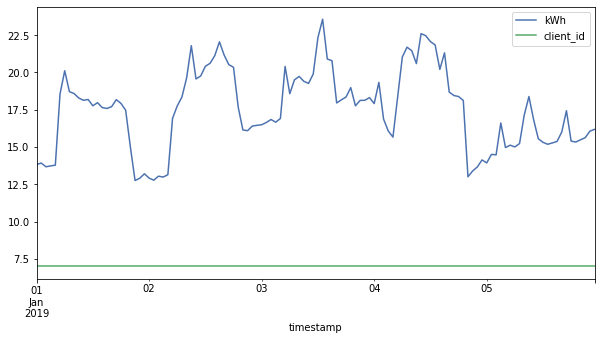

In [150]:
ts.loc[ts['client_id'] == 7].head(120).plot(figsize=(10,5))

加特征

In [4]:
# winter 12,1,2
begin = '2019-01-01'
end = '2019-04-01'
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])
exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2019-01-01","holidays"] = 1
ts["holidays"] = exo["holidays"]

date = ts.index
timestamp_s = date.map(datetime.timestamp)
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
ts = ts[['kWh', 'Week sin', 'Week cos', 'holidays', 'client_id']]
ts

,kWh,Week sin,Week cos,holidays,client_id
timestamp,,,,,
2019-01-01 00:00:00,0.00,-8.660254e-01,-0.500000,1,0
2019-01-01 01:00:00,0.00,-8.841154e-01,-0.467269,1,0
2019-01-01 02:00:00,0.00,-9.009689e-01,-0.433884,1,0
2019-01-01 03:00:00,0.00,-9.165623e-01,-0.399892,1,0
2019-01-01 04:00:00,0.00,-9.308737e-01,-0.365341,1,0
...,...,...,...,...,...
2019-03-31 20:00:00,3.33,-1.913309e-13,-1.000000,0,99
2019-03-31 21:00:00,2.91,-3.739119e-02,-0.999301,0,99
2019-03-31 22:00:00,3.06,-7.473009e-02,-0.997204,0,99


归一化

In [5]:
for i in range(client_n):
    scaler = MinMaxScaler(feature_range=(0, 1))
    norm = scaler.fit_transform(ts.loc[ts['client_id']==i][['kWh','Week sin','Week cos']])
    nonnorm = ts.loc[ts['client_id']==i][['holidays', 'client_id']]
    if i == 0:
        ts_normalized = pd.DataFrame(np.concatenate([norm,nonnorm], axis=1),
                                 columns = ts.columns.values,
                                index = ts.loc[ts['client_id']==i].index)
    else:
        ts_normalized = pd.concat([ts_normalized, pd.DataFrame(np.concatenate([norm,nonnorm], axis=1),
                                 columns = ts.columns.values,
                                index = ts.loc[ts['client_id']==i].index)])
ts_normalized

,kWh,Week sin,Week cos,holidays,client_id
timestamp,,,,,
2019-01-01 00:00:00,0.0,0.066987,0.12132,1,0
2019-01-01 01:00:00,0.0,0.057942,0.140494,1,0
2019-01-01 02:00:00,0.0,0.049516,0.16005,1,0
2019-01-01 03:00:00,0.0,0.041719,0.179962,1,0
2019-01-01 04:00:00,0.0,0.034563,0.200202,1,0
...,...,...,...,...,...
2019-03-31 20:00:00,0.054731,0.5,0.0,0,99
2019-03-31 21:00:00,0.041744,0.481304,0.00035,0,99
2019-03-31 22:00:00,0.046382,0.462635,0.001398,0,99


# 聚类

In [6]:
# kmeans_cluster_n = int(0.2*client_n)
kmeans_cluster_n = 10

min_len = 10000
for i in range(client_n):
    tmp = ts_normalized.loc[ts_normalized['client_id']==i]
    if len(tmp) <= min_len:
        min_len = len(tmp)
print(min_len)
        
for i in range(client_n):
    if i == 0:
        ts_array = np.expand_dims(np.squeeze(ts_normalized.loc[ts_normalized['client_id']==i][['kWh']][:min_len].values), axis=0)
    else:
        ts_array = np.concatenate([ts_array, np.expand_dims(np.squeeze(ts_normalized.loc[ts_normalized['client_id']==i][['kWh']][:min_len].values), axis=0)], axis=0)
kmeans = KMeans(n_clusters=kmeans_cluster_n, random_state=0).fit(ts_array)
k_c = Counter(kmeans.labels_)
print(k_c)

216
Counter({1: 18, 5: 14, 0: 11, 2: 11, 3: 10, 8: 9, 9: 8, 4: 7, 6: 7, 7: 5})


In [7]:
for i in range(kmeans_cluster_n):
    exec('ts_normalized{} = pd.DataFrame(columns=ts_normalized.columns)'.format(i))

for i in range(client_n):
    for j in range(kmeans_cluster_n):
        if kmeans.labels_[i] == j:
            exec('ts_normalized{} = pd.concat([ts_normalized{},ts_normalized.loc[ts_normalized.client_id=={}]])'.format(j,j,i))

In [8]:
cluster_id = 1
exec('ts_normalized = ts_normalized{}'.format(cluster_id))

In [11]:
ts_normalized

,kWh,Week sin,Week cos,holidays,client_id
2019-01-11 00:00:00,0.028986,0.78166,0.913119,0,8
2019-01-11 01:00:00,0.043478,0.79691,0.902299,0,8
2019-01-11 02:00:00,0.028986,0.811745,0.890916,0,8
2019-01-11 03:00:00,0.028986,0.826144,0.878986,0,8
2019-01-11 04:00:00,0.043478,0.840086,0.866526,0,8
...,...,...,...,...,...
2019-03-31 20:00:00,0.079646,0.5,0.0,0,558
2019-03-31 21:00:00,0.099115,0.481304,0.00035,0,558
2019-03-31 22:00:00,0.099115,0.462635,0.001398,0,558
2019-03-31 23:00:00,0.100885,0.444018,0.003144,0,558


# 划分数据集

In [9]:
train_end = '2019-03-17'
val_end = '2019-03-24'
test_end = '2019-04-01'

# train_end = '2018-12-17'
# val_end = '2018-12-24'
# test_end = '2019-01-01'

test_df = ts_normalized[val_end:]
train_df = ts_normalized[:train_end]
val_df = ts_normalized[train_end:val_end]

column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

,kWh,Week sin,Week cos,holidays,client_id
2019-01-01 00:00:00,0.20342,0.066987,0.25,1,12
2019-01-01 01:00:00,0.220522,0.057942,0.266366,1,12
2019-01-01 02:00:00,0.205221,0.049516,0.283058,1,12
2019-01-01 03:00:00,0.206121,0.041719,0.300054,1,12
2019-01-01 04:00:00,0.224122,0.034563,0.317329,1,12
...,...,...,...,...,...
2019-03-17 19:00:00,0.046382,0.518696,0.00035,0,99
2019-03-17 20:00:00,0.05102,0.5,0.0,0,99
2019-03-17 21:00:00,0.049165,0.481304,0.00035,0,99
2019-03-17 22:00:00,0.050093,0.462635,0.001398,0,99


# 制作滑窗

In [10]:
def split_sequence(df, fea_width=24, label_width=1, shift=1, label_col_indices=[0], randomize = True):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list): list of the columns for the labels.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
#     print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
#           .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [11]:
fea_width, label_width, shift, label_col_indices = 24, 1, 1, [0]
X_ts = []
y_ts = []
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

def to_tensor(ls):
    return Variable(torch.FloatTensor(np.array(ls, dtype=np.float64))).to(device)

client_unique = ts_normalized.client_id.unique()
for i in client_unique:
    X_ts_tmp, y_ts_tmp = split_sequence(ts_normalized.loc[ts_normalized['client_id']==i].drop('client_id',axis=1),randomize=False)
    X_ts.append(to_tensor(X_ts_tmp))
    y_ts.append(to_tensor(y_ts_tmp))
    
    X_train_tmp, y_train_tmp = split_sequence(train_df.loc[train_df['client_id']==i].drop('client_id',axis=1))
    X_train.append(to_tensor(X_train_tmp))
    y_train.append(to_tensor(y_train_tmp))
    
    X_val_tmp, y_val_tmp = split_sequence(val_df.loc[val_df['client_id']==i].drop('client_id',axis=1))
    X_val.append(to_tensor(X_val_tmp))
    y_val.append(to_tensor(y_val_tmp))
    
    X_test_tmp, y_test_tmp = split_sequence(test_df.loc[test_df['client_id']==i].drop('client_id',axis=1))
    X_test.append(to_tensor(X_test_tmp))
    y_test.append(np.array(y_test_tmp, dtype=np.float64))

X_ 中有100个tensor，每个tensor对应是每个client的滑窗数据

In [22]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(X_train[0]))
print(len(X_train[0][0]))
print(len(X_train[0][0][0]))
print(type(X_train))
print(type(X_train[0]))
print(type(X_train[0][0]))
print(type(X_train[0][0][0]))
print(type(X_train[0][0][0][0]))

50
50
49
192
24
4
<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


# 建立模型，并训练

In [12]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [13]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for j in range(1, len(w)):
            w_avg[k] += w[j][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg
    
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [14]:
# FL parameter
FL_rounds = 500
local_train_round = 1
k = int(0.1*len(X_train))

# network parameter & setup
learning_rate = 1e-4
input_size = 4
hidden_size = 512
num_layers = 2
num_classes = 1

# initialize

model_glob = LSTM(num_classes, input_size, hidden_size, num_layers)
model_glob.apply(init_weights)
w_glob = model_glob.state_dict()

w_total = []
model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.to(device)
# 一开始都会用glob的参数
for i in range(len(X_train)):
    w_total.append(copy.deepcopy(model_glob.state_dict()))

criterion = torch.nn.MSELoss().to(device)   # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, min_lr=1e-7, eps=1e-08)

rmse_record = []
mape_record = []
loss_record = []
val_loss_record = []
time_record = []

# training

for epoch in progress_bar(range(FL_rounds)):
    start = time.time()
    upload_clients = random.sample(range(0, len(X_train)), k)
    w_upload = []
    for i in upload_clients:
        model.load_state_dict(copy.deepcopy(w_glob))
        for j in range(local_train_round):
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_train[i])
    
            loss = torch.sqrt(criterion(y_pred, y_train[i]))
            loss.backward()
    
            optimizer.step()
    
            model.eval()
            valid = model(X_val[i])
            val_loss = torch.sqrt(criterion(valid, y_val[i]))
            scheduler.step(val_loss)
        
        w_upload.append(copy.deepcopy(model.state_dict()))
        w_total[i] = copy.deepcopy(model.state_dict())
        
    # agg
    w_glob = FedAvg(w_upload)
    end = time.time()
    
    for i in range(len(client_unique)):
        if len(X_test[i]) == 0:
            continue
        model.load_state_dict(copy.deepcopy(w_glob))
        scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts.loc[ts['client_id']==client_unique[i]][["kWh"]])
        y_test_pred = scaler_kwh.inverse_transform(model(X_test[i]).cpu().detach().numpy())
        y_test_obs = scaler_kwh.inverse_transform(y_test[i])
        if i == 0:
            rmse = round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)
            mape = round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)
        else:
            rmse += round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)
            mape += round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)
    rmse = np.mean(rmse)
    mape = np.mean(mape)
    
    rmse_record.append(rmse)
    mape_record.append(mape)
    loss_record.append(loss.item())
    val_loss_record.append(val_loss.item())
    time_record.append(end-start)
    
    print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " % (epoch, loss.item(), val_loss.item()))
    print('RMSE ' + str(rmse) + '\nMAPE ' + str(mape))
    

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " % (epoch, loss.item(), val_loss.item()))

Epoch: 0, loss: 0.34349 validation loss:  0.21776 
RMSE 358.77
MAPE 15.729999999999999
Epoch: 1, loss: 0.36829 validation loss:  0.29306 
RMSE 309.63
MAPE 9.730000000000002
Epoch: 2, loss: 0.35703 validation loss:  0.24567 
RMSE 267.19999999999993
MAPE 7.18
Epoch: 3, loss: 0.24182 validation loss:  0.20985 
RMSE 235.78999999999996
MAPE 9.240000000000002
Epoch: 4, loss: 0.29417 validation loss:  0.28620 
RMSE 219.92999999999998
MAPE 13.260000000000002
Epoch: 5, loss: 0.22123 validation loss:  0.20155 
RMSE 222.44
MAPE 17.88
Epoch: 6, loss: 0.21647 validation loss:  0.25316 
RMSE 235.39999999999998
MAPE 21.49
Epoch: 7, loss: 0.27490 validation loss:  0.29190 
RMSE 247.64
MAPE 23.82
Epoch: 8, loss: 0.24908 validation loss:  0.24475 
RMSE 253.36000000000004
MAPE 24.81
Epoch: 9, loss: 0.22749 validation loss:  0.24833 
RMSE 252.22000000000003
MAPE 24.74
Epoch: 10, loss: 0.24318 validation loss:  0.22520 
RMSE 244.48
MAPE 23.589999999999996
Epoch: 11, loss: 0.26607 validation loss:  0.25451 

Epoch: 94, loss: 0.13757 validation loss:  0.13348 
RMSE 121.02999999999999
MAPE 7.38
Epoch: 95, loss: 0.14160 validation loss:  0.12530 
RMSE 120.50999999999999
MAPE 7.640000000000001
Epoch: 96, loss: 0.14209 validation loss:  0.14091 
RMSE 120.38000000000002
MAPE 8.080000000000002
Epoch: 97, loss: 0.13620 validation loss:  0.14254 
RMSE 120.71
MAPE 8.510000000000002
Epoch: 98, loss: 0.12797 validation loss:  0.11928 
RMSE 120.47999999999999
MAPE 8.52
Epoch: 99, loss: 0.14418 validation loss:  0.12769 
RMSE 119.74
MAPE 8.3
Epoch: 100, loss: 0.13233 validation loss:  0.11745 
RMSE 119.88999999999997
MAPE 8.49
Epoch: 101, loss: 0.11610 validation loss:  0.10947 
RMSE 119.27000000000001
MAPE 8.3
Epoch: 102, loss: 0.13396 validation loss:  0.13697 
RMSE 118.38999999999999
MAPE 7.94
Epoch: 103, loss: 0.14000 validation loss:  0.15213 
RMSE 117.95
MAPE 7.840000000000002
Epoch: 104, loss: 0.13396 validation loss:  0.11718 
RMSE 118.04000000000002
MAPE 8.080000000000002
Epoch: 105, loss: 0.14

Epoch: 187, loss: 0.07605 validation loss:  0.07443 
RMSE 87.23
MAPE 4.76
Epoch: 188, loss: 0.08100 validation loss:  0.07829 
RMSE 87.44
MAPE 5.070000000000001
Epoch: 189, loss: 0.11564 validation loss:  0.10577 
RMSE 88.09000000000002
MAPE 5.36
Epoch: 190, loss: 0.11677 validation loss:  0.10601 
RMSE 88.25
MAPE 5.430000000000001
Epoch: 191, loss: 0.09668 validation loss:  0.09605 
RMSE 88.51
MAPE 5.610000000000001
Epoch: 192, loss: 0.11525 validation loss:  0.12753 
RMSE 87.25000000000001
MAPE 5.29
Epoch: 193, loss: 0.10066 validation loss:  0.10210 
RMSE 87.1
MAPE 5.3
Epoch: 194, loss: 0.09691 validation loss:  0.09804 
RMSE 87.94999999999997
MAPE 5.529999999999999
Epoch: 195, loss: 0.08932 validation loss:  0.09699 
RMSE 88.19
MAPE 5.65
Epoch: 196, loss: 0.11801 validation loss:  0.11264 
RMSE 86.12
MAPE 5.090000000000001
Epoch: 197, loss: 0.07867 validation loss:  0.07489 
RMSE 84.77000000000001
MAPE 4.700000000000001
Epoch: 198, loss: 0.08128 validation loss:  0.08309 
RMSE 84.9

Epoch: 284, loss: 0.10193 validation loss:  0.11615 
RMSE 77.94999999999999
MAPE 4.0600000000000005
Epoch: 285, loss: 0.10270 validation loss:  0.09921 
RMSE 78.28999999999999
MAPE 3.98
Epoch: 286, loss: 0.10909 validation loss:  0.09440 
RMSE 79.04
MAPE 4.09
Epoch: 287, loss: 0.09786 validation loss:  0.08980 
RMSE 78.66000000000003
MAPE 4.24
Epoch: 288, loss: 0.09516 validation loss:  0.09214 
RMSE 79.89999999999999
MAPE 4.75
Epoch: 289, loss: 0.11062 validation loss:  0.10011 
RMSE 83.13
MAPE 5.420000000000001
Epoch: 290, loss: 0.09087 validation loss:  0.08718 
RMSE 83.29
MAPE 5.630000000000001
Epoch: 291, loss: 0.11371 validation loss:  0.09739 
RMSE 80.37999999999998
MAPE 5.27
Epoch: 292, loss: 0.07256 validation loss:  0.06563 
RMSE 76.78
MAPE 4.6899999999999995
Epoch: 293, loss: 0.06916 validation loss:  0.07038 
RMSE 76.17999999999998
MAPE 4.290000000000001
Epoch: 294, loss: 0.08289 validation loss:  0.08041 
RMSE 78.09
MAPE 4.14
Epoch: 295, loss: 0.07262 validation loss:  0.0

Epoch: 380, loss: 0.09940 validation loss:  0.09862 
RMSE 72.30000000000001
MAPE 3.440000000000001
Epoch: 381, loss: 0.07473 validation loss:  0.07319 
RMSE 72.50999999999999
MAPE 3.4100000000000006
Epoch: 382, loss: 0.09369 validation loss:  0.08783 
RMSE 72.77
MAPE 3.6299999999999994
Epoch: 383, loss: 0.07326 validation loss:  0.07851 
RMSE 72.6
MAPE 3.880000000000001
Epoch: 384, loss: 0.08826 validation loss:  0.08372 
RMSE 72.27
MAPE 4.160000000000001
Epoch: 385, loss: 0.08157 validation loss:  0.08753 
RMSE 72.24
MAPE 4.210000000000001
Epoch: 386, loss: 0.07615 validation loss:  0.07647 
RMSE 71.25
MAPE 3.9100000000000006
Epoch: 387, loss: 0.09491 validation loss:  0.08761 
RMSE 70.2
MAPE 3.7299999999999995
Epoch: 388, loss: 0.07018 validation loss:  0.07556 
RMSE 70.05999999999999
MAPE 3.6199999999999997
Epoch: 389, loss: 0.07456 validation loss:  0.06929 
RMSE 70.71000000000001
MAPE 3.5300000000000002
Epoch: 390, loss: 0.08869 validation loss:  0.09733 
RMSE 71.55999999999999
MA

Epoch: 474, loss: 0.06529 validation loss:  0.07115 
RMSE 67.33000000000001
MAPE 3.8000000000000007
Epoch: 475, loss: 0.07640 validation loss:  0.07248 
RMSE 66.91
MAPE 3.770000000000001
Epoch: 476, loss: 0.06925 validation loss:  0.06608 
RMSE 66.11000000000001
MAPE 3.5199999999999996
Epoch: 477, loss: 0.07145 validation loss:  0.06883 
RMSE 66.00000000000001
MAPE 3.3300000000000005
Epoch: 478, loss: 0.08358 validation loss:  0.07852 
RMSE 66.35
MAPE 3.2
Epoch: 479, loss: 0.08332 validation loss:  0.09413 
RMSE 66.5
MAPE 3.2100000000000004
Epoch: 480, loss: 0.08469 validation loss:  0.08432 
RMSE 65.98
MAPE 3.2100000000000004
Epoch: 481, loss: 0.07894 validation loss:  0.07936 
RMSE 65.42
MAPE 3.2600000000000002
Epoch: 482, loss: 0.07055 validation loss:  0.06879 
RMSE 65.16
MAPE 3.31
Epoch: 483, loss: 0.09822 validation loss:  0.08061 
RMSE 65.13
MAPE 3.3800000000000003
Epoch: 484, loss: 0.08130 validation loss:  0.08106 
RMSE 65.67000000000002
MAPE 3.5300000000000002
Epoch: 485, los

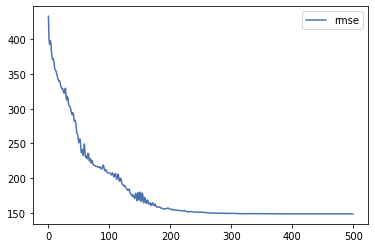

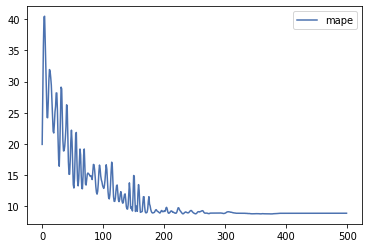

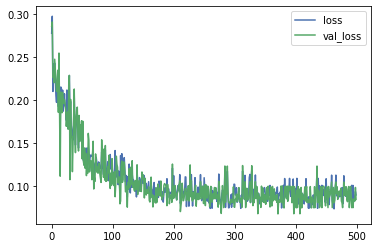

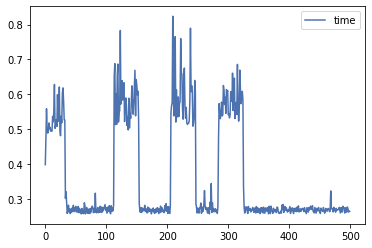

182.34133124351501

In [220]:
plt.plot(range(len(rmse_record)), rmse_record, label = 'rmse')
plt.legend()
plt.show()

plt.plot(range(len(mape_record)), mape_record, label = 'mape')
plt.legend()
plt.show()

plt.plot(range(len(loss_record)), loss_record, label = 'loss')
plt.plot(range(len(val_loss_record)), val_loss_record, label = 'val_loss')
plt.legend()
plt.show()

plt.plot(range(len(time_record)), time_record, label = 'time')
plt.legend()
plt.show()

np.sum(time_record)

In [ ]:
model.eval()
# model_defect.eval()
## Inverse Normalize 
y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
# y_test_pred_defect = scaler_kwh.inverse_transform(model_defect(X_test).cpu().detach().numpy())
y_test_obs = scaler_kwh.inverse_transform(y_test)

print('The root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nThe MAPE of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))

print('The defect root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred_defect)),2)) +
      '\nThe defect MAPE of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred_defect),2)))

Text(0, 0.5, 'kWh')

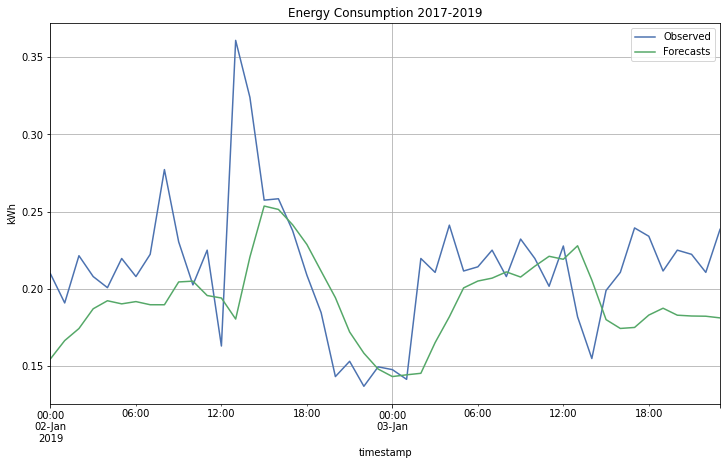

In [15]:
# test_id = (kmeans.labels_==cluster_id).argmax(axis=0)
test_id = 0

scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts.loc[ts['client_id']==test_id][["kWh"]])
y_pred = scaler_kwh.inverse_transform(model(X_ts[0]).cpu().detach().numpy())
# y_pred_defect = scaler_kwh.inverse_transform(model_defect(X_ts[0]).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_ts[0].cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
# pred_df_defect = pd.DataFrame(y_pred_defect, index = ts.index[-len(y_pred_defect):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df[:48],pred_df[:48]],axis=1)
# plot_df_defect = pd.concat([pred_df_defect],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = '-', grid=True)
# plot_df_defect.plot(ax=ax,figsize=(12,7),style = 'o', grid=True)
# ax.legend(["Defect","Observed", "Forecasts"])
ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")